# Import pic

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Load Data from Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
# data= pd.read_csv('/content/drive/MyDrive/DAD7202/hotel_bookings.csv')

Mounted at /content/drive


In [3]:
import cv2

In [4]:
label_class = {'exotic_shorthair':0,'scottish_fold':1 ,'american_shorthair':2,'british_shorthair':3}

In [5]:
list(label_class.keys())

['exotic_shorthair',
 'scottish_fold',
 'american_shorthair',
 'british_shorthair']

# Change path

In [6]:
from sklearn.model_selection import train_test_split
x_train = []
x_test =[]
x_val = []

y_train = []
y_test = []
y_val = []

img_size = (224,224)

for c in list(label_class.keys()):
  filename = [i for i in os.listdir('/content/drive/MyDrive/RCNN/{0}'.format(c)) if 'jpg' in i]
  train_index, val_index, = train_test_split(filename, test_size = 0.2, random_state = 1)
  val_index, test_index, = train_test_split(val_index, test_size = 0.5, random_state = 1)

  for i in train_index:
    img = cv2.imread('/content/drive/MyDrive/RCNN/{0}/{1}'.format(c,i))
    # print('/content/drive/MyDrive/RCNN/{0}/{1}'.format(c,i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,img_size)
    x_train.append(img)
    y_train.append([label_class[c]])

  for i in val_index:
    img = cv2.imread('/content/drive/MyDrive/RCNN/{0}/{1}'.format(c,i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,img_size)
    x_val.append(img)
    y_val.append([label_class[c]])

  for i in test_index:
    img = cv2.imread('/content/drive/MyDrive/RCNN/{0}/{1}'.format(c,i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,img_size)
    x_test.append(img)
    y_test.append([label_class[c]])

# Random train test

In [7]:
import random

random.seed(0)
train_index = [i for i in range(len(x_train))]
test_index = [i for i in range(len(x_test))]

random.shuffle(train_index)
random.shuffle(test_index)

x_train = [x_train[i] for i in train_index]
y_train = [y_train[i] for i in train_index]

x_test = [x_test[i] for i in test_index]
y_test = [y_test[i] for i in test_index]

In [8]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


In [9]:
np.random.seed(1234)
tf.random.set_seed(5678)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
img_height = 224
img_width = 224
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.3,value_range=(0, 255), seed=64),
  ]
)

# Augment

In [12]:
aug_x_train = []
aug_y_train = []

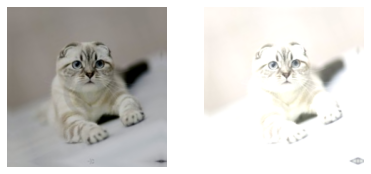

In [13]:
images =  np.array(x_train)

plt.figure(figsize=(10, 10))
for i in range(2):
  ax = plt.subplot(3, 3, i + 1)
  augmented_images = data_augmentation(images)
  plt.imshow(augmented_images[0].numpy().astype("uint8") )
  plt.axis('off')
  for index,i in enumerate(augmented_images):
    aug_x_train.append(i.numpy().astype("uint8"))
    aug_y_train.append(y_train[index])
    

american_shorthair


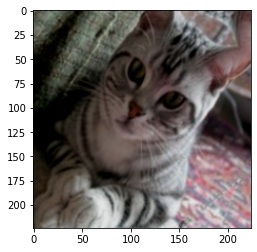

In [14]:
print(list(label_class.keys())[aug_y_train[1001][0]])
plt.imshow(aug_x_train[1001])


In [15]:
for index,i in enumerate(x_train):
  
  seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
  #img = tf.image.stateless_random_hue(x_train[0], 0.5, seed).numpy().astype("uint8")
  img = tf.image.stateless_random_hue(i, 0.5, seed).numpy().astype("uint8")
  aug_x_train.append(img)
  aug_y_train.append(y_train[index])

In [16]:
len(aug_x_train)

1860

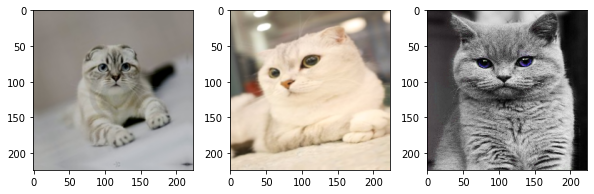

In [17]:
plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 3, 1)
plt.imshow(aug_x_train[0])

ax = plt.subplot(3, 3, 2)
plt.imshow(aug_x_train[639])

ax = plt.subplot(3, 3, 3)
plt.imshow(aug_x_train[1278])

In [18]:
# plt.figure(figsize=(10, 10))

# ax = plt.subplot(3, 3, 1)
# plt.imshow(x_train[0])

# ax = plt.subplot(3, 3, 2)
# plt.imshow(augmented_images[0].numpy().astype("uint8"))

# ax = plt.subplot(3, 3, 3)
# seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
# plt.imshow(tf.image.stateless_random_hue(x_train[0], 0.5, seed).numpy().astype("uint8"))

In [19]:
# Load the ImageNet VGG-16 model, ***excluding*** the latter part regarding the classifier
# Default of input_shape is 224x224x3 for VGG-16
#img_w,img_h = 32,32     # image size of CIFAR-10

#backbone mobilenetv3
mobilenet_extractor = tf.keras.applications.MobileNetV3Small(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

mobilenet_extractor.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                    

In [20]:
# backbone : mobilenetv3

import tensorflow as tf
x_train_mobilenet = tf.keras.applications.mobilenet_v3.preprocess_input(np.array(aug_x_train))
x_test_mobilenet = tf.keras.applications.mobilenet_v3.preprocess_input(np.array(x_test))

print( x_train_mobilenet.dtype, x_train_mobilenet.shape, np.min(x_train_mobilenet), np.max(x_train_mobilenet) )
print( x_test_mobilenet.dtype, x_test_mobilenet.shape, np.min(x_test_mobilenet), np.max(x_test_mobilenet) )

uint8 (1860, 224, 224, 3) 0 255
uint8 (79, 224, 224, 3) 0 255


# Fine tune
# Change Unfreeze layer

In [21]:
# freeze all layer
mobilenet_extractor.trainable = False

In [22]:
# unfreeze each layer
# [179:185] --> เลือก layer ที่จะ unfreeze จะ unfreeeze ตั้งแต่ layer 179 - layer 185

for i,layer in enumerate(mobilenet_extractor.layers[25:28]):  
     layer.trainable = True

# Display layer name

In [23]:
# Recursively freeze all layers in the model

for i,layer in enumerate(mobilenet_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = rescaling , trainable = False
Layer 2: name = Conv , trainable = False
Layer 3: name = Conv/BatchNorm , trainable = False
Layer 4: name = tf.__operators__.add , trainable = False
Layer 5: name = re_lu , trainable = False
Layer 6: name = tf.math.multiply , trainable = False
Layer 7: name = multiply , trainable = False
Layer 8: name = expanded_conv/depthwise/pad , trainable = False
Layer 9: name = expanded_conv/depthwise , trainable = False
Layer 10: name = expanded_conv/depthwise/BatchNorm , trainable = False
Layer 11: name = re_lu_1 , trainable = False
Layer 12: name = expanded_conv/squeeze_excite/AvgPool , trainable = False
Layer 13: name = expanded_conv/squeeze_excite/Conv , trainable = False
Layer 14: name = expanded_conv/squeeze_excite/Relu , trainable = False
Layer 15: name = expanded_conv/squeeze_excite/Conv_1 , trainable = False
Layer 16: name = tf.__operators__.add_1 , trainable = False
Layer 17: name = re_lu_2 , train

# **Classifier**

In [24]:
x = mobilenet_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x) #256/512/1024
x = tf.keras.layers.Dropout(0.5)(x) #0.5/0.75
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=mobilenet_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [25]:
# base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
# preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
# prediction_layer = tf.keras.layers.Dense(4)

In [26]:
# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# # x = preprocess_input(x)
# x = base_model(x, training=False)
# # x = global_average_layer(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# model = tf.keras.Model(inputs, new_outputs)
# model.summary()

# Change learning rate

In [27]:
#model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] ) 

#change learning rate

model.compile( loss="sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam (learning_rate=0.001, 
                                                                                             name = 'Adam'), 
                                                                                             metrics=["acc"] )
                                                                                            

In [28]:
checkpoint_filepath = "bestmodel_epoch.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                                              save_weights_only=True,
                                                                                              monitor='val_acc',
                                                                                              mode='max',
                                                                                              save_best_only=True)

# Change batch_size and epochs

In [29]:
%%time

# change batch_size, epochs

history = model.fit( x_train_mobilenet, np.array(aug_y_train), batch_size=256, 
                                                               epochs=50, 
                                                               verbose=1,
                                                               validation_data=(x_test_mobilenet, np.array(y_test)), 
                                                               callbacks=[model_checkpoint_callback])
                    

Epoch 1/50
8/8 [==============================] - 65s 7s/step - loss: 6.4136 - acc: 0.5097 - val_loss: 0.7595 - val_acc: 0.7215
Epoch 2/50
8/8 [==============================] - 54s 7s/step - loss: 0.6557 - acc: 0.7538 - val_loss: 0.6837 - val_acc: 0.7722
Epoch 3/50
8/8 [==============================] - 55s 7s/step - loss: 0.4771 - acc: 0.8108 - val_loss: 0.5003 - val_acc: 0.8101
Epoch 4/50
8/8 [==============================] - 54s 7s/step - loss: 0.2885 - acc: 0.8839 - val_loss: 0.4546 - val_acc: 0.8608
Epoch 5/50
8/8 [==============================] - 55s 7s/step - loss: 0.2270 - acc: 0.9145 - val_loss: 0.4242 - val_acc: 0.8608
Epoch 6/50
8/8 [==============================] - 54s 7s/step - loss: 0.1478 - acc: 0.9478 - val_loss: 0.3943 - val_acc: 0.8734
Epoch 7/50
8/8 [==============================] - 53s 7s/step - loss: 0.1328 - acc: 0.9500 - val_loss: 0.4373 - val_acc: 0.8481
Epoch 8/50
8/8 [==============================] - 58s 7s/step - loss: 0.1192 - acc: 0.9602 - val_loss: 0

In [30]:
model.load_weights('/content/bestmodel_epoch.hdf5')

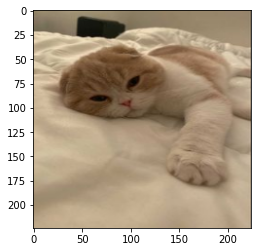

In [31]:
test_img = x_test[35]
plt.imshow(test_img)

In [32]:
# change backbone name

test_mobilenet = tf.keras.applications.mobilenet_v3.preprocess_input(np.array([test_img]))

In [33]:
pred = model.predict(test_mobilenet)

1/1 [==============================] - 1s 982ms/step


In [34]:
list(label_class.keys())[np.argmax(pred)]

'scottish_fold'

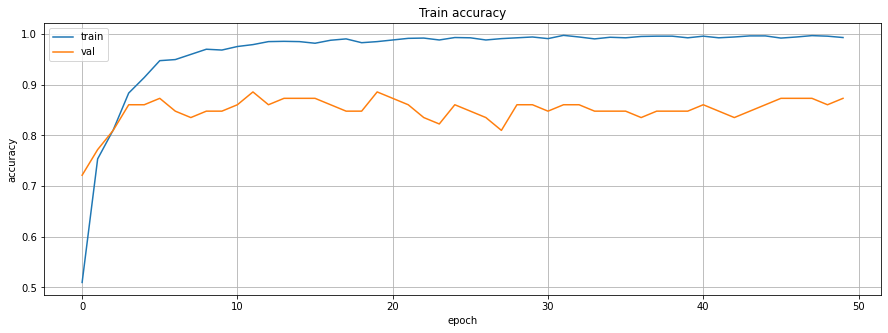

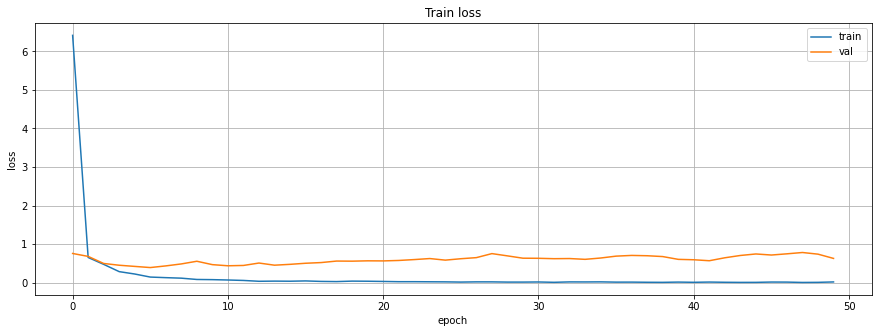

In [35]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

In [36]:
# Test using the model on x_test[i]
# change backbone name

X_val_res = tf.keras.applications.mobilenet_v3.preprocess_input(np.array(x_val))
y_pred = model.predict( X_val_res )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
round_pred = [np.argmax(i) for i in y_pred]

3/3 [==============================] - 1s 266ms/step


# Validate Score

In [37]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_val,round_pred))

#fpr, tpr, thresholds = metrics.roc_curve(y_test, round_pred)
#print('AUC score',metrics.auc(fpr, tpr))



              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.74      0.89      0.81        19
           2       1.00      0.89      0.94        19
           3       0.88      0.83      0.86        18

    accuracy                           0.86        76
   macro avg       0.87      0.86      0.86        76
weighted avg       0.87      0.86      0.86        76



# Train Score

In [38]:
# Test using the model on x_test[i]

y_pred = model.predict( x_train_mobilenet )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
round_pred = [np.argmax(i) for i in y_pred]

59/59 [==============================] - 22s 366ms/step


In [39]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(aug_y_train,round_pred))

# fpr, tpr, thresholds = metrics.roc_curve(y_test, round_pred)
# print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       492
           1       1.00      1.00      1.00       468
           2       0.99      1.00      1.00       456
           3       1.00      0.99      1.00       444

    accuracy                           1.00      1860
   macro avg       1.00      1.00      1.00      1860
weighted avg       1.00      1.00      1.00      1860



# Test Score

In [40]:
# Test using the model on x_test[i]

y_pred = model.predict( x_test_mobilenet )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
round_pred = [np.argmax(i) for i in y_pred]

3/3 [==============================] - 1s 274ms/step


In [41]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_test,round_pred))

# fpr, tpr, thresholds = metrics.roc_curve(y_test, round_pred)
# print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.80      0.80      0.80        20
           2       0.95      1.00      0.97        19
           3       0.94      0.84      0.89        19

    accuracy                           0.89        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.89      0.89      0.89        79



In [55]:
label_class = {'exotic_shorthair':0,'scottish_fold':1 ,'american_shorthair':2,'british_shorthair':3}

In [56]:
new_img = []

In [57]:
for i in range(4):
  for index,j in enumerate(y_train):
    if j == [i]:
      new_img.append(x_train[index])
      break

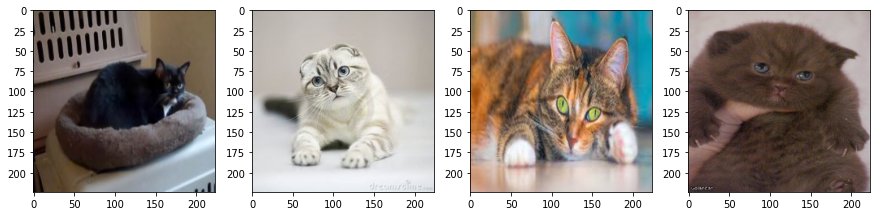

In [58]:
plt.figure(figsize=(15, 15))

for i in range(4):
  ax = plt.subplot(1, 4, i+1)
  plt.imshow(new_img[i])

In [59]:
pre_img =  tf.keras.applications.mobilenet_v3.preprocess_input(np.array(new_img))

In [60]:
original_model = tf.keras.applications.MobileNetV3Small(weights = "imagenet")

In [61]:
predictions = original_model.predict(pre_img) 

1/1 [==============================] - 1s 1s/step


In [62]:
predictions

array([[2.6560034e-05, 6.6077409e-06, 1.0836492e-04, ..., 6.2414379e-05,
        3.3748314e-05, 3.4310713e-03],
       [3.9000584e-05, 1.9993106e-05, 9.0038675e-06, ..., 3.4587299e-06,
        1.1176268e-04, 1.3531723e-04],
       [2.5359161e-05, 1.5943253e-04, 4.5222161e-05, ..., 4.4834028e-06,
        4.0556455e-04, 3.7624231e-05],
       [5.4478041e-05, 2.9195860e-05, 3.1614924e-05, ..., 2.8321412e-05,
        1.4394285e-04, 1.4368267e-04]], dtype=float32)

In [63]:
from keras.applications.imagenet_utils import decode_predictions 
label = decode_predictions(predictions) 

In [64]:
label

[[('n04265275', 'space_heater', 0.31782046),
  ('n04493381', 'tub', 0.11383336),
  ('n02104365', 'schipperke', 0.09615954),
  ('n04040759', 'radiator', 0.062300626),
  ('n04553703', 'washbasin', 0.03911774)],
 [('n02123394', 'Persian_cat', 0.3920251),
  ('n02124075', 'Egyptian_cat', 0.13179146),
  ('n02127052', 'lynx', 0.08314667),
  ('n02123045', 'tabby', 0.07572211),
  ('n02123159', 'tiger_cat', 0.075503945)],
 [('n02123045', 'tabby', 0.5678263),
  ('n02124075', 'Egyptian_cat', 0.18648686),
  ('n02123159', 'tiger_cat', 0.11753796),
  ('n03598930', 'jigsaw_puzzle', 0.009748635),
  ('n04074963', 'remote_control', 0.0062723113)],
 [('n02123394', 'Persian_cat', 0.8170094),
  ('n02342885', 'hamster', 0.027155815),
  ('n02442845', 'mink', 0.01475132),
  ('n02127052', 'lynx', 0.0062530963),
  ('n02124075', 'Egyptian_cat', 0.0050636004)]]

                                                                                              MobileNetV3Small


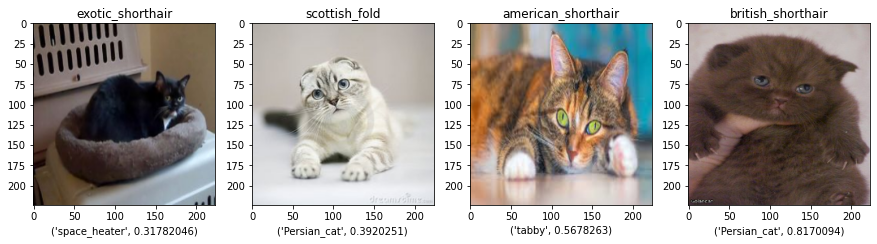

In [65]:
plt.figure(figsize=(15, 15))
print('                                                                                              MobileNetV3Small')
for i in range(4):
  
  ax = plt.subplot(1, 4, i+1)
  plt.imshow(new_img[i])
  plt.title(list(label_class.keys())[i])
  plt.xlabel(label[i][0][1:])

In [66]:
pred = model.predict(pre_img)

1/1 [==============================] - 0s 84ms/step


                                                                                              MobileNetV3Small


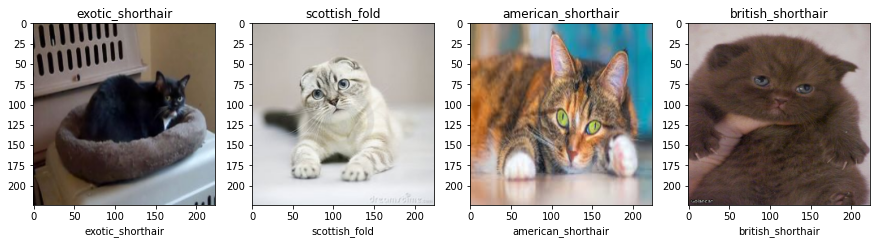

In [67]:
plt.figure(figsize=(15, 15))
print('                                                                                              MobileNetV3Small')
for i in range(4):
  ax = plt.subplot(1, 4, i+1)
  plt.imshow(new_img[i])
  plt.title(list(label_class.keys())[i])
  plt.xlabel(list(label_class.keys())[np.argmax(pred[i])])